In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
from matplotlib import pyplot as plt
print(tf.__version__)

2.1.0


### Text Categorization, Part I

In the previous tutorials, we have learned how to classify image using deep neural networks with TensorFlow 2.x. However, image classification is only one of many important applications of deep learning. In this tutorial, we're going to dive into another important area where deep learning has made significant advancement in recent years: natural language processing. We are going to start with the task of text categorization, in which we assign classes or categories to text according to its content. Let's get started! 

For this tutorial, we're going to use the IMDB movie review dataset. This dataset is contained in the `tensorflow_datasets` collection which comes along with `tensorflow`.

#### 1. Loading data from `tensorflow_datasets`

The IMDB movie review dataset is a dataset for binary sentiment classification, comprised of 25,000 highly polar movie reviews for training and 25,000 for testing. There are also additional unlabeled data for use as well but we're not going to use them for this supervised learning task. Each review is associated with a label categorizing it as a positive or negative review.

Since a piece of text is consisted of words, we cannot process them directly with a neural network architecture. The first step in a NLP task is usually to represent each word with an integer, and this is done with an "encoder" (not to be confused with the encoder as a neural network architecture). The encoder basically transforms a piece of text into an array of integers with a fixed vocabulary size (number of different integers). `tensorflow_datasets` comes with text encoders so we don't need to be worried about this process for now. There are different implementations of this encoder (with different vocabulary sizes), and we're going to use a version that has a vocabulary of about 8,000 tokens. Note that since sequence models almost always require padding due to variable input length, the token 0 is reserved for padding. First, let's see how to load this data from `tensorflow_datasets`. 

In [2]:
# The `load` method is the easiest way to load a dataset from `tensorflow_datasets`. It returns a `tf.data.Dataset` instance.
# We specify the version of encoded data we desire by specifying the `subwords8k` path. 
# We specify the path to store this data with the `data_dir` argument.
# The `with_info` option returns an additional object containing some information about this dataset.
# The `as_supervised` option tells it to only return labeled data.

imdb_dataset, info = tfds.load('imdb_reviews/subwords8k', data_dir='./datasets/', with_info=True, as_supervised=True)

W0518 16:50:21.322405 139834113791808 text_feature.py:61] TFDS datasets with text encoding are deprecated and will be removed in a future version. Instead, you should use the plain text version and tokenize the text using `tensorflow_text` (See: https://www.tensorflow.org/tutorials/tensorflow_text/intro#tfdata_example)


Let's look at some properties of this dataset. First, let's inspect the `info` variable. For example, it tells us which encoder was used to generate the integer tokens from raw text.

In [3]:
encoder = info.features['text'].encoder
print('Vocabulary size: %d' % encoder.vocab_size)

Vocabulary size: 8185


We can directly use this encoder to encode a random piece of text that we pass to it.

In [4]:
# Use the `encode` method and pass it a string.
print(encoder.encode('This is a piece of example raw text.'))

[62, 9, 4, 612, 6, 1271, 7703, 7961, 3433, 7975]


We see that the encoder transforms a string into a sequence of integers. Since 0 is reserved for padding, this encoding process always returns a list of positive numbers. We can also use the encoder to do the reverse process: translate a list of integers into a string of raw text.

In [5]:
# Use the `decode` method and pass it a list of integers.
print(encoder.decode([4025, 222, 6307, 2327, 4043, 2120, 7975]))

Hello TensorFlow.


You might wonder why a list of 7 tokens only represent 2 words. This is because encoding is not done in a word-by-word fashion with this encoder. If we take a closer look at which token corresponds to which word, we can get a better idea of the encoding mechanism.

In [6]:
for token in [4025, 222, 6307, 2327, 4043, 2120, 7975]:
    print('%s ----> %s' % (token, encoder.decode([token])))

4025 ----> Hell
222 ----> o 
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
7975 ----> .


It looks like the encoder is just transforming specific substrings into their corresponding tokens. This is one of the simplest ways of enconding, but is certainly not the best, as words are broken apart and might lose their original meaning. This is to some extent limited by our choice of vocabulary size, since 8,000 tokens cannot fully express the abundance of words that appear in the reviews. If we had a larger vocabulary there would be other ways to encode the texts while preserving their word boundaries and meaning as much as possible. We're not going into details here for the purpose of this tutorial.

Now that we have loaded the entire dataset, let's split out training and test sets. This is already done by `tensorflow_datasets`.

In [7]:
train_examples, test_examples = imdb_dataset['train'], imdb_dataset['test']

# We need to apply transformations for `tf.data.Dataset` to get batched data for training and test sets.
# For the training set, we first need to shuffle the dataset, and then generate batches with a defined batch size.

# Since each review has a different length, we need to pad the shorter sequences so that they're all of the same size. To do this,
# we need to apply the `padded_batch` method, where you speficy the resulting shape for each dimension for each component.

# For each data point, we have a sequence of variable size, so we specify `None` in order to pad to the longest sequence in
# each batch. We also have a scalar label which we don't need to pad, so we just pass an empty list. 
train_dataset = train_examples.shuffle(buffer_size=10000).padded_batch(batch_size=64, padded_shapes=([None],[]))

# For the test set, we don't need to shuffle the dataset but we still need to do padding on each batch.
test_dataset = test_examples.padded_batch(batch_size=64, padded_shapes=([None],[]))

In [8]:
# Let's take a look at one batch of training data.
batch_input, batch_label = list(train_dataset.take(1).as_numpy_iterator())[0]
print('Shape of input batch', batch_input.shape)
print(batch_input, '\n')

print('Shape of input labels', batch_label.shape)
print(batch_label)

Shape of input batch (64, 1247)
[[ 274  252 7748 ...    0    0    0]
 [  19 1612 5512 ...    0    0    0]
 [ 133   97  911 ...    0    0    0]
 ...
 [  62   32   25 ...    0    0    0]
 [  12 6081   36 ...    0    0    0]
 [7963   19 1720 ...    0    0    0]] 

Shape of input labels (64,)
[1 1 1 0 1 1 0 0 0 1 0 1 0 0 0 0 1 0 1 1 1 0 1 1 0 1 1 0 1 1 0 0 1 0 0 1 0
 1 1 0 1 1 1 1 0 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 0 1 1]


We see that all sequences in the first batch are padded to a length of 1,404. The 0 tokens represent padding. Now that the dataset is presented in numerical form and padded, we are ready to build a neural network model to process it. For sequence data, we usually use recurrent neural networks (RNNs). However, before building RNN blocks, there is something we need to do, and that is embedding.

#### 2. Building an RNN model

Although the encoder has already transformed words into integers, they're still not in the best format to be interpreted by deep learning models. The integer encoding is arbitrary and does not capture relationships between words. A better idea is to use a vector of fixed length to represent each token. In addition, we would want similar tokens to be embedded close together. Of course, we cannot provide these embeddings for now, but we can define the length of these vectors and let the neural network figure out what vectors to embed for each token. This is called an embedding layer. 

Mathematically, an embedding layer is basically a 2D tensor of size [`vocab_size`, `embed_size`], meaning that each token in the vocabulary has an embedding of `embed_size`. When input passes through this layer, basically for each token a lookup is performed, taking out the row corresponding to that specific token. Therefore, after passing through the embedding layer, a sequence of length `seq_length` will become a 2D tensor of size [`seq_length`, `embed_size`]. The embedding layer is directly available in `tf.keras.layers`.

For this task, let's use a two-layer bi-directional LSTM architecture. Since the model can be represented in a linear fashion, we're going to use `tf.keras.Sequential` to build the model.

In [9]:
model = keras.Sequential([
    keras.layers.Embedding(encoder.vocab_size, 32), # Specify vocab size and embedding size. We use an embedding size of 32.
    
    # To use bi-directional layers, we need to wrap the layer inside of `tf.keras.layers.Bidirectional`.
    # For RNNs, we can return different things from each layer. For this layer, we want the output from each cell so that they can be passed on to the next layer.
    # To do this, we need to specify `return_sequences` to `True`, or else the layer would only return the output of the last cells (from the two directions).
    keras.layers.Bidirectional(keras.layers.LSTM(32, return_sequences=True)),
    
    # The output of the previous layer is [batch_size, batch_longest_sequence_length, 64].
    # The last dimension of 64 came from the concatenation of the output from two directions. 
    # You can also do summing or averaging by specifying the `merge_mode` argument.
    
    # For the second LSTM layer, we're going to take only the output from the last cells from each direction.
    keras.layers.Bidirectional(keras.layers.LSTM(32)),
    keras.layers.Dense(64, activation=keras.activations.relu), # Dense layer
    keras.layers.Dropout(0.5), # Dropout layer to mitigate overfitting
    keras.layers.Dense(1) # Output layer. For binary classification we can just output the probability of the positive class.
])

In [10]:
# We can call the `summary` method of our model to get an overview of our model architecture and parameters.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          261920    
_________________________________________________________________
bidirectional (Bidirectional (None, None, 64)          16640     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 307,617
Trainable params: 307,617
Non-trainable params: 0
__________________________________________________

#### 3. Compiling and training the model

We compile our model the usual way by calling the `compile` method and specifying the loss function, the optimizer to use and the metrics to calculate in each epoch.

In [11]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), # Since we have a single prediction for each data point, we should use `BinaryCrossentropy`.
              optimizer=tf.keras.optimizers.Adam(1e-4), # We can pass a optimizer instance to the `optimizer` argument.
              metrics=['accuracy'])

In [12]:
# Now, we can train our model by calling `fit`.
history = model.fit(train_dataset, epochs=10)

Epoch 1/10
391/391 [==============================] - 1064s 3s/step - loss: 0.6842 - accuracy: 0.5144
Epoch 2/10
391/391 [==============================] - 1060s 3s/step - loss: 0.4428 - accuracy: 0.8010
Epoch 3/10
391/391 [==============================] - 1060s 3s/step - loss: 0.3159 - accuracy: 0.8764
Epoch 4/10
391/391 [==============================] - 1011s 3s/step - loss: 0.2635 - accuracy: 0.9030
Epoch 5/10
391/391 [==============================] - 978s 3s/step - loss: 0.2301 - accuracy: 0.9202
Epoch 6/10
391/391 [==============================] - 1573s 4s/step - loss: 0.2056 - accuracy: 0.9309
Epoch 7/10
391/391 [==============================] - 1200s 3s/step - loss: 0.1834 - accuracy: 0.9411
Epoch 8/10
391/391 [==============================] - 945s 2s/step - loss: 0.1695 - accuracy: 0.9470
Epoch 9/10
391/391 [==============================] - 933s 2s/step - loss: 0.1567 - accuracy: 0.9534
Epoch 10/10
391/391 [==============================] - 1045s 3s/step - loss: 0.1487 -

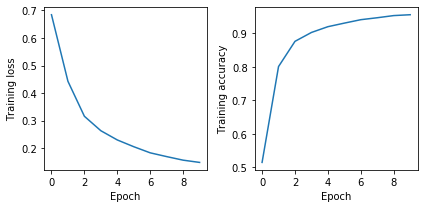

In [15]:
# Visualize training performance

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(6)
fig.set_figheight(3)

ax1.plot(range(10), history.history['loss'])
ax1.set_ylabel('Training loss')
ax1.set_xlabel('Epoch')

ax2.plot(range(10), history.history['accuracy'])
ax2.set_ylabel('Training accuracy')
ax2.set_xlabel('Epoch')

fig.tight_layout()

We see that training has been pretty successful! Training accuracy reached to 95.6% after 10 epochs. Notice that training an RNN took much longer time than training a CNN, and this is just one of the difficulties of training RNN models, especially when you have long sequences. Let's see how well our model performs on the test set.

In [17]:
test_loss, test_accuracy = model.evaluate(test_dataset)

print('Test Loss: %f' % test_loss)
print('Test Accuracy: %f' % test_accuracy)

    391/Unknown - 319s 815ms/step - loss: 0.4521 - accuracy: 0.8484Test Loss: 0.452103
Test Accuracy: 0.848360


The test performance is good, but much lower than training performance. This means that our model is suffering from the problem of overfitting. Nevertheless, this tutorial has demonstrated how we can deal with text data with neural networks. After we have the model, we can also categorize unseen movie reviews.

In [19]:
review_text = 'a punchy, gritty experience that will poke and grab at your emotions in surprising and meaningful ways'
encoded_text = encoder.encode(review_text)
encoded_text = tf.cast(encoded_text, tf.float32) # Model requires float input
predictions = model.predict(tf.expand_dims(encoded_text, 0)) # Add a `batch` dimension of 1.
print(predictions)

[[0.93577397]]


This high prediction score means that the model categorizes this review as a positive one.

In this tutorial we have learned how to do text categorization with an RNN. One thing that can be improved here is that we can apply masking to the paddings so that they would not be taken into account as real data, which may give us a model with better performance. In the next tutorial, we're first going to divert from text categorization a little bit and learn about text generation.